In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('/MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /MNIST_data/train-labels-idx1-ubyte.gz
Extracting /MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
num_features = 784
neurons = [32, 32]
learning_rate = 0.001
batch_size = 128
epochs = 100

In [0]:
input_features = tf.placeholder(dtype=tf.float32, shape=[None, num_features])

In [0]:
weights = {
    'encoder_weights_1': tf.Variable(tf.random_normal(shape=[num_features,
                                                             neurons[0]])),
    'encoder_weights_2': tf.Variable(tf.random_normal(shape=[neurons[0],
                                                             neurons[1]])),
    'decoder_weights_1': tf.Variable(tf.random_normal(shape=[neurons[1],
                                                             neurons[0]])),
    'decoder_weights_2': tf.Variable(tf.random_normal(shape=[neurons[0],
                                                             num_features]))
}

biases = {
    'encoder_biases_1': tf.Variable(tf.random_normal(shape=[neurons[0]])),
    'encoder_biases_2': tf.Variable(tf.random_normal(shape=[neurons[1]])),
    'decoder_biases_1': tf.Variable(tf.random_normal(shape=[neurons[0]])),
    'decoder_biases_2': tf.Variable(tf.random_normal(shape=[num_features]))
}

In [0]:
def encoder(x):
  layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_weights_1']),
                              biases['encoder_biases_1']))
  layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_weights_2']),
                              biases['encoder_biases_2']))
  return layer_2

In [0]:
def decoder(x):
  layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_weights_2']),
                              biases['decoder_biases_2']))
  layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_weights_2']),
                                        biases['decoder_biases_2']))
  return layer_2

In [0]:
def plot_generated_image(images):
  plt.figure(figsize=(16, 16))
  for index in range(len(images)):
    plt.subplot(2, 5, int(index + 1))
    plt.imshow(images[index])

In [0]:
z = encoder(input_features)
x_ = decoder(z)

In [0]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_, labels=input_features))
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [0]:
init_op = tf.global_variables_initializer()

Epoch 0, loss : 0.7047724723815918
Epoch 1, loss : 0.6963655352592468
Epoch 2, loss : 0.6944440007209778
Epoch 3, loss : 0.6927324533462524
Epoch 4, loss : 0.6922124624252319
Epoch 5, loss : 0.691443145275116
Epoch 6, loss : 0.6908402442932129
Epoch 7, loss : 0.6892775893211365
Epoch 8, loss : 0.688855767250061
Epoch 9, loss : 0.6877421736717224
Epoch 10, loss : 0.6876658201217651
Epoch 11, loss : 0.6865055561065674
Epoch 12, loss : 0.6865466237068176
Epoch 13, loss : 0.6847490668296814
Epoch 14, loss : 0.684572160243988
Epoch 15, loss : 0.6843071579933167
Epoch 16, loss : 0.6839386820793152
Epoch 17, loss : 0.684063732624054
Epoch 18, loss : 0.6835711598396301
Epoch 19, loss : 0.683898389339447
Epoch 20, loss : 0.6817729473114014
Epoch 21, loss : 0.6826159954071045
Epoch 22, loss : 0.6824620962142944
Epoch 23, loss : 0.6816810965538025
Epoch 24, loss : 0.6818130016326904
Epoch 25, loss : 0.6821877360343933
Epoch 26, loss : 0.6815023422241211
Epoch 27, loss : 0.6808763742446899
Epoch 2

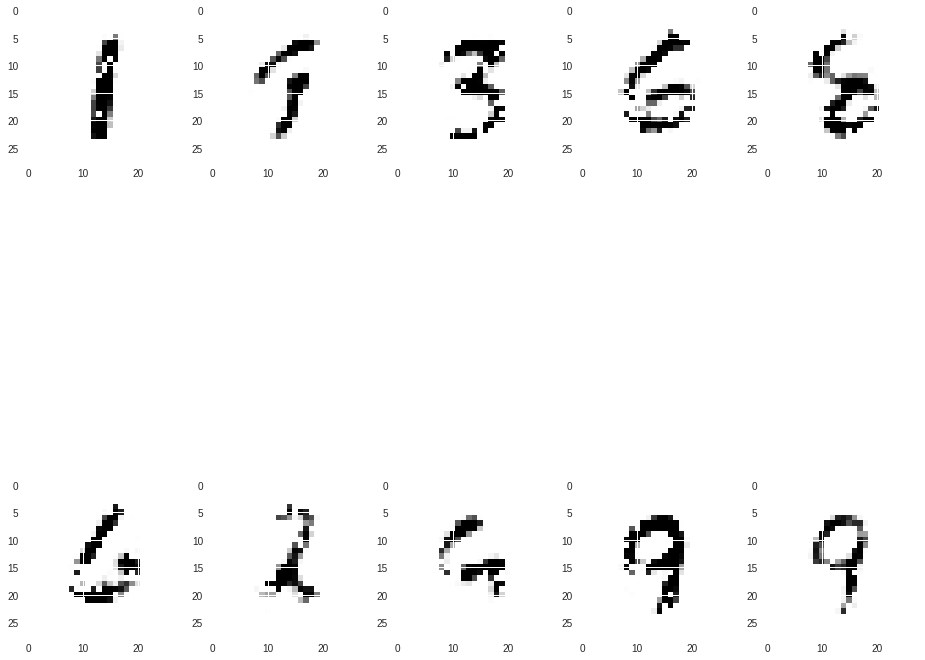

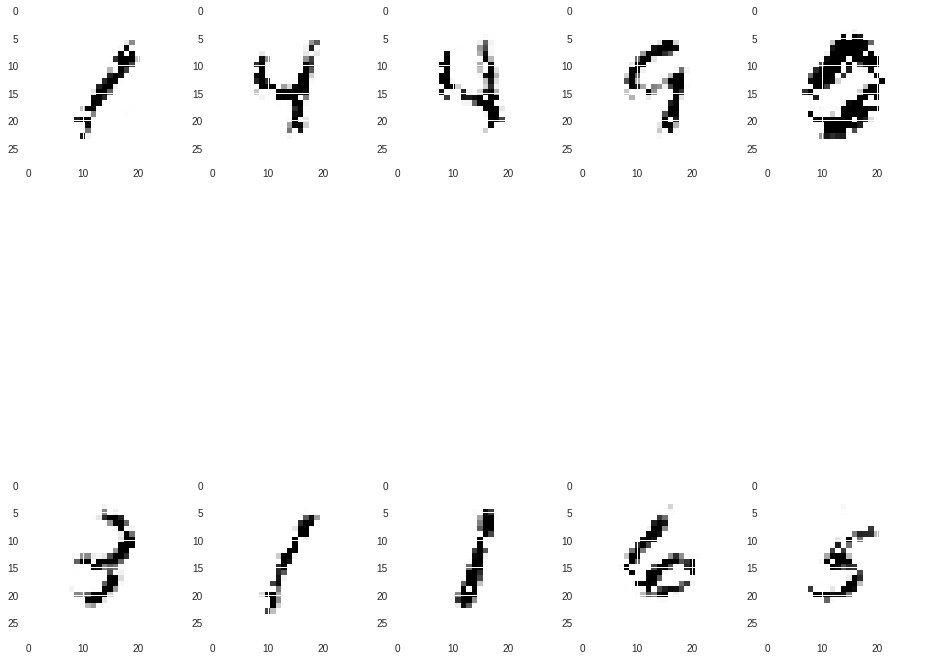

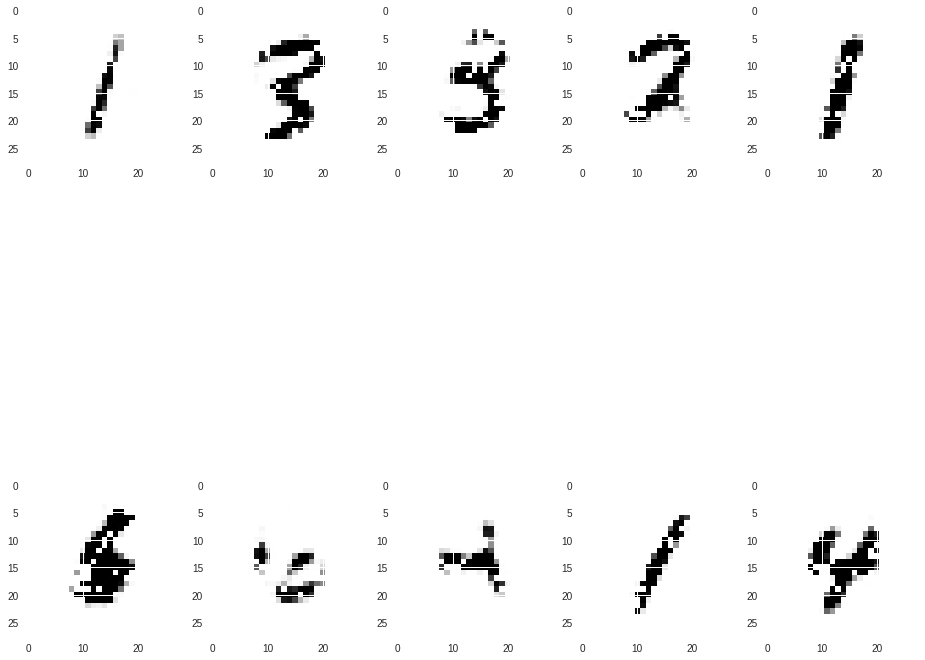

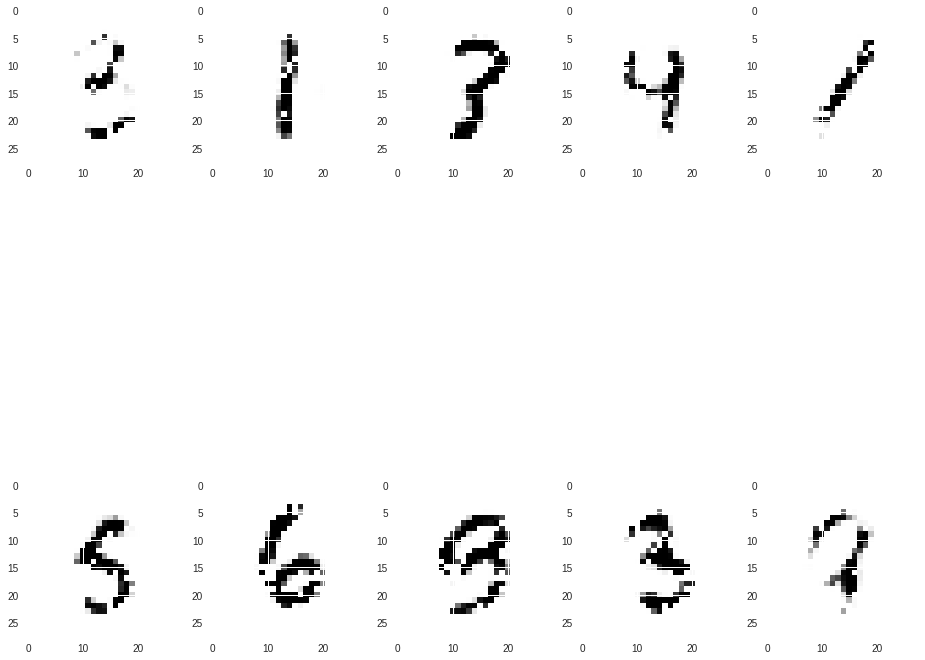

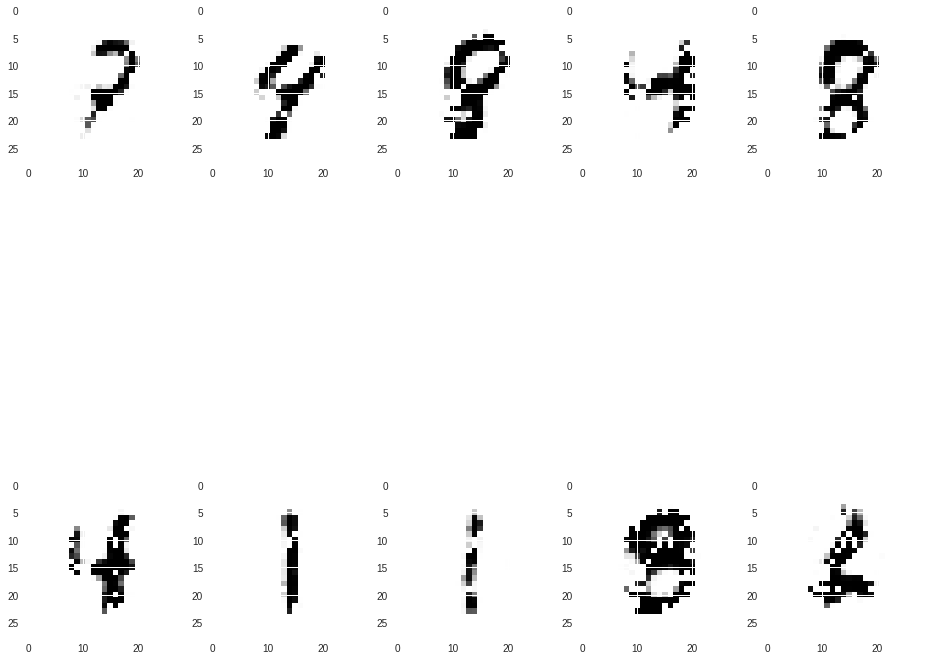

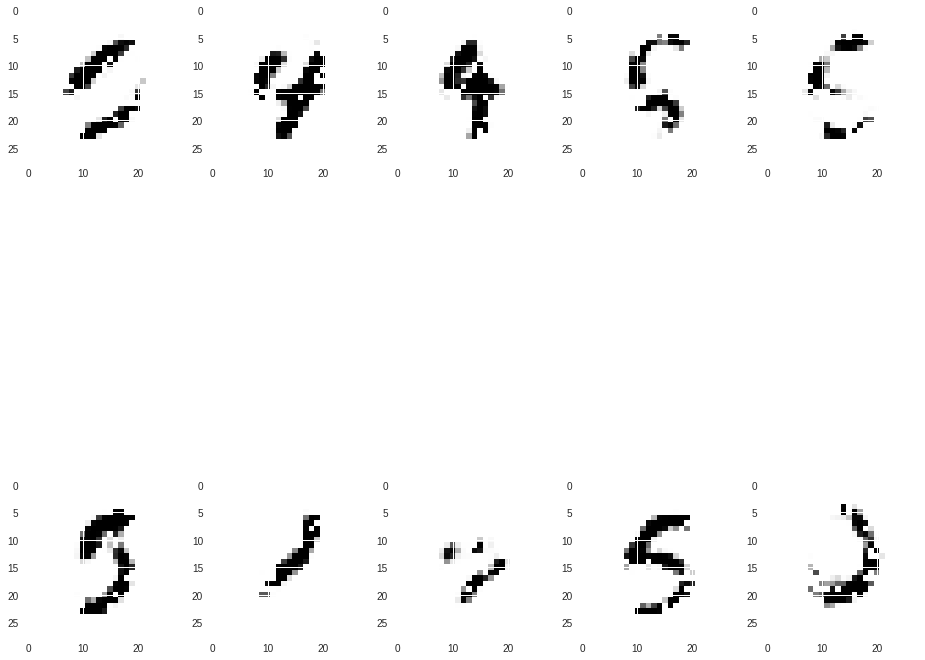

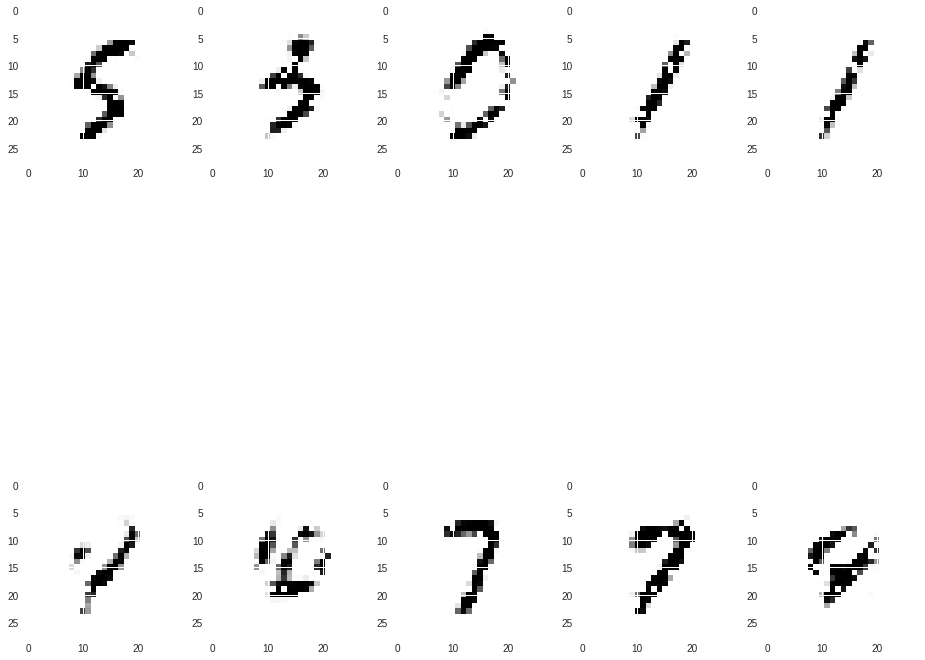

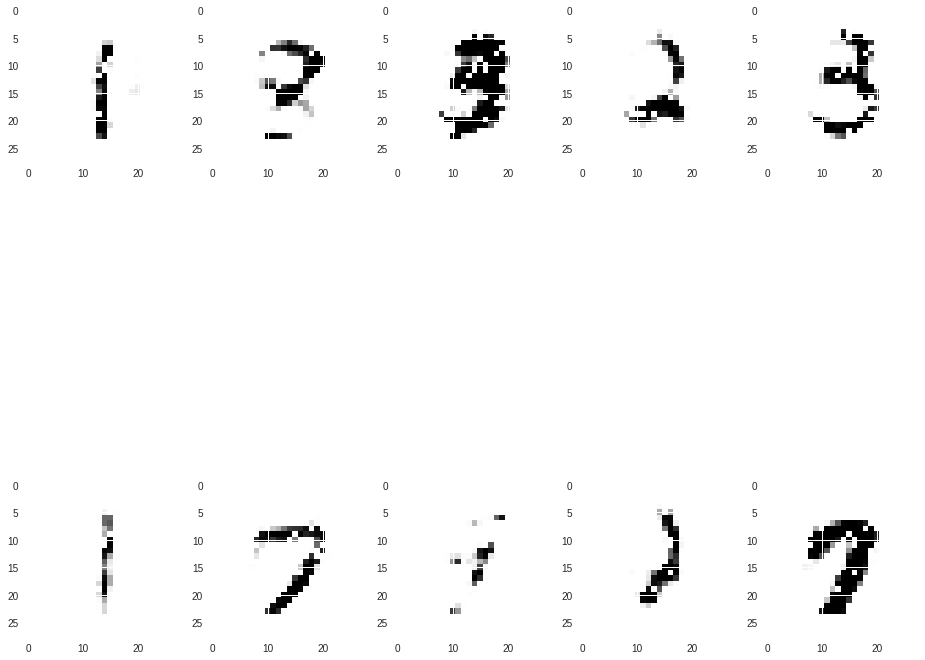

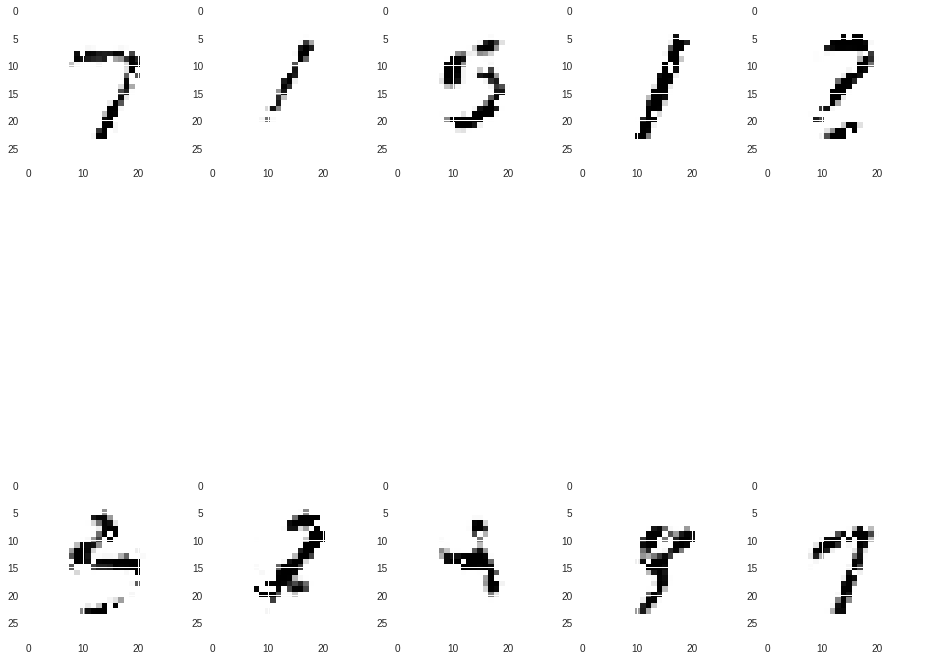

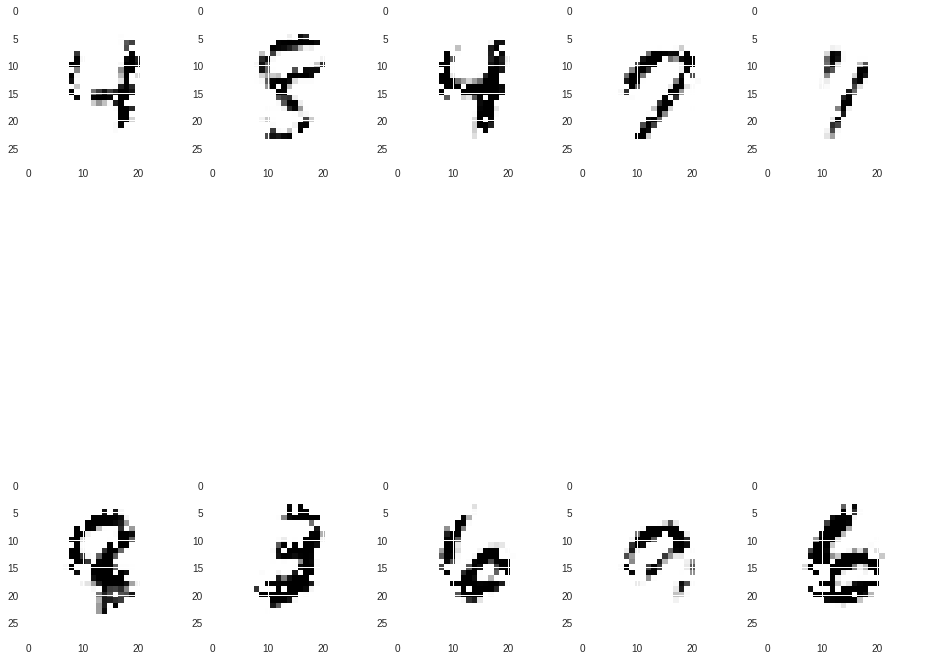

In [37]:
with tf.Session() as sess:
  
  sess.run(init_op)
  
  for epoch in range(epochs):
    for mini_batch in range(int(mnist.train.num_examples / batch_size)):
      batch_x, _ = mnist.train.next_batch(batch_size=batch_size)
      _, loss_ = sess.run([train_op, loss], feed_dict={input_features: batch_x})
    print('Epoch {}, loss : {}'.format(epoch, loss_))
  
  for index in range(10):
    batch_x, _ = mnist.test.next_batch(10)
    g_ = sess.run(x_, feed_dict={input_features: batch_x})
    plot_generated_image(g_.reshape(-1, 28, 28))